In [30]:
# Step 0: Integrate original CSV and CellProfiler results (df2), then prepare aggregator mapping using first 9 characters.

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold

# Define a simple structure to hold a valid aggregator sample
class AggregateSample:
    """
    A structure to hold a single 'XXXXX_median_aggregated.tiff' file's path
    and its associated label (Metadata_pert_iname).
    """
    def __init__(self, filepath, label_str):
        self.filepath = filepath
        self.label_str = label_str

# Function to extract the first 9 characters as a prefix
def get_prefix9(fname):
    """
    Extract the first 9 characters from a filename.
    E.g., 'r16c03f06p01-ch3sk1fk1fl1.tiff' -> 'r16c03f06'
    """
    return fname[:9]

# Read original CSV and CellProfiler result CSV (df2)
original_csv = r"E:\5243\project2\metadata_BR00116991.csv"
cellprofiler_csv = r"E:\5243\project2\MyExpt_Image.csv"

df_orig = pd.read_csv(original_csv)
df2 = pd.read_csv(cellprofiler_csv)

# Add a new column 'Prefix' in both DataFrames based on filename:
df_orig["Prefix"] = df_orig["FileName_OrigRNA"].apply(get_prefix9)
df2["Prefix"] = df2["FileName_DNA"].apply(get_prefix9)

# Merge the two DataFrames on 'Prefix'
df_merged = pd.merge(df_orig, df2, on="Prefix", how="inner")

# Optionally, you can inspect df_merged.columns to see all combined information.
print(f"Number of merged records: {df_merged.shape[0]}")

# Build aggregator mapping based on the merged DataFrame:
# Use the CellProfiler image file name (FileName_DNA) as the key to check existence in the image folder.
def build_aggregated_mapping_from_df(merged_df, root_dir):
    """
    Build aggregator mapping from the merged DataFrame.
    For each row, use the first 9 characters (Prefix) to construct the expected
    aggregator filename: Prefix + '_median_aggregated.tiff'. Then, check for conflicts.
    Returns valid_samples, missing_files, conflict_files, and a mapping label_to_idx.
    """
    aggregator_dict = {}  # aggregator filename -> set of labels
    # Use the compound label from original CSV, e.g., 'Metadata_pert_iname'
    for idx, row in merged_df.iterrows():
        # Use original compound label
        label_str = row['Metadata_pert_iname']
        # Use df2's FileName_DNA as reference for actual image file
        file_name = row['FileName_DNA']
        prefix9 = get_prefix9(file_name)
        agg_fname = prefix9 + "_median_aggregated.tiff"
        
        if agg_fname not in aggregator_dict:
            aggregator_dict[agg_fname] = set()
        aggregator_dict[agg_fname].add(label_str)
    
    valid_samples = []
    missing_files = []
    conflict_files = []
    
    for agg_fname, label_set in aggregator_dict.items():
        if len(label_set) > 1:
            conflict_files.append(agg_fname)
            continue
        label_str = list(label_set)[0]
        full_path = os.path.join(root_dir, agg_fname)
        if os.path.exists(full_path):
            valid_samples.append((full_path, label_str))
        else:
            missing_files.append(agg_fname)
    
    print("\n=== Step 0 (Merged) Summary ===")
    print(f"Total aggregator entries found in merged CSV: {len(aggregator_dict)}")
    print(f"  Conflicts (multiple distinct labels): {len(conflict_files)}")
    for cf in conflict_files:
        print("    ", cf)
    print(f"  Missing aggregator files: {len(missing_files)}")
    for mf in missing_files:
        print("    ", mf)
    print(f"  Valid aggregator files (no conflict, exist in folder): {len(valid_samples)}")
    
    unique_labels = sorted(set([lab for (_, lab) in valid_samples]))
    label_to_idx = {lab: i for i, lab in enumerate(unique_labels)}
    
    return valid_samples, label_to_idx, missing_files, conflict_files

# Define root directory for images (same as before)
data_dir = r"E:\5243\project2"
image_dir = os.path.join(data_dir, "downsampled_data", "downsampled_data")

# Build aggregated mapping from merged DataFrame
valid_samples, label_to_idx, missing_files, conflict_files = build_aggregated_mapping_from_df(df_merged, image_dir)

# Prepare for Stratified K-Fold cross-validation
numeric_labels = []
for (_, lab_str) in valid_samples:
    numeric_labels.append(label_to_idx[lab_str])
numeric_labels = np.array(numeric_labels)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_data = valid_samples

print("\n=== Final Merged Step 0 Results ===")
print(f"Useable aggregator image files: {len(all_data)}")
print(f"Unique labels: {len(label_to_idx)}")


Number of merged records: 2867

=== Step 0 (Merged) Summary ===
Total aggregator entries found in merged CSV: 2867
  Conflicts (multiple distinct labels): 0
  Missing aggregator files: 0
  Valid aggregator files (no conflict, exist in folder): 2867

=== Final Merged Step 0 Results ===
Useable aggregator image files: 2867
Unique labels: 250


In [31]:
# Step 1: 5-Fold training with Resize + IncrementalPCA + Logistic Regression

import numpy as np
from PIL import Image
import torch
import math

from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import torchvision.transforms as T

transform_resize = T.Compose([
    T.Resize((64, 64)),  # reduce resolution
    T.ToTensor(),
])

def incremental_pca_fit(X_paths, label_to_idx, n_components=100, batch_size=256):
    ipca = IncrementalPCA(n_components=n_components)
    num_imgs = len(X_paths)
    num_batches = math.ceil(num_imgs / batch_size)
    idx_start = 0
    
    for b in range(num_batches):
        batch_paths = X_paths[idx_start:idx_start+batch_size]
        idx_start += batch_size
        
        batch_data_list = []
        for fp in batch_paths:
            img = Image.open(fp).convert('RGB')
            img_t = transform_resize(img)
            img_np = img_t.numpy().ravel()
            batch_data_list.append(img_np)
        
        if len(batch_data_list) == 0:
            continue
        batch_data = np.stack(batch_data_list, axis=0)
        
        ipca.partial_fit(batch_data)
    
    return ipca

def transform_with_ipca(X_paths, ipca, batch_size=256):
    data_proj_list = []
    idx_start = 0
    num_imgs = len(X_paths)
    num_batches = math.ceil(num_imgs / batch_size)
    
    for b in range(num_batches):
        batch_paths = X_paths[idx_start:idx_start+batch_size]
        idx_start += batch_size
        
        batch_data_list = []
        for fp in batch_paths:
            img = Image.open(fp).convert('RGB')
            img_t = transform_resize(img)
            img_np = img_t.numpy().ravel()
            batch_data_list.append(img_np)
        
        if len(batch_data_list) == 0:
            continue
        batch_data = np.stack(batch_data_list, axis=0)
        
        batch_proj = ipca.transform(batch_data)
        data_proj_list.append(batch_proj)
    
    X_proj = np.concatenate(data_proj_list, axis=0)
    return X_proj

def run_5fold_ipca_logreg(all_data, label_to_idx, skf, numeric_labels, 
                          n_components=100, batch_size=256):
    fold_idx = 1
    for train_index, test_index in skf.split(np.zeros(len(numeric_labels)), numeric_labels):
        print(f"\n=== Fold {fold_idx} ===")
        train_subset = [all_data[i] for i in train_index]
        test_subset  = [all_data[i] for i in test_index]
        
        X_train_paths = [fp for (fp,_) in train_subset]
        y_train_list  = [label_to_idx[lab_str] for (_,lab_str) in train_subset]
        
        X_test_paths = [fp for (fp,_) in test_subset]
        y_test_list  = [label_to_idx[lab_str] for (_,lab_str) in test_subset]
        
        y_train = np.array(y_train_list)
        y_test  = np.array(y_test_list)
        
        print("Train data count:", len(X_train_paths))
        print("Test  data count:", len(X_test_paths))
        
        ipca = incremental_pca_fit(X_train_paths, label_to_idx, 
                                   n_components=n_components, 
                                   batch_size=batch_size)
        X_train_pca = transform_with_ipca(X_train_paths, ipca, batch_size=batch_size)
        X_test_pca  = transform_with_ipca(X_test_paths,  ipca, batch_size=batch_size)
        
        print("Train data shape after PCA:", X_train_pca.shape)
        print("Test  data shape after PCA:",  X_test_pca.shape)
        
        clf = LogisticRegression(max_iter=1000)
        clf.fit(X_train_pca, y_train)
        y_pred = clf.predict(X_test_pca)
        
        acc = accuracy_score(y_test, y_pred)
        print(f"Fold {fold_idx} Accuracy: {acc:.4f}")
        
        fold_idx += 1

# usage:
run_5fold_ipca_logreg(all_data, label_to_idx, skf, numeric_labels, 
                      n_components=100, batch_size=256)



=== Fold 1 ===
Train data count: 2293
Test  data count: 574
Train data shape after PCA: (2293, 100)
Test  data shape after PCA: (574, 100)
Fold 1 Accuracy: 0.1707

=== Fold 2 ===
Train data count: 2293
Test  data count: 574
Train data shape after PCA: (2293, 100)
Test  data shape after PCA: (574, 100)
Fold 2 Accuracy: 0.1603

=== Fold 3 ===
Train data count: 2294
Test  data count: 573
Train data shape after PCA: (2294, 100)
Test  data shape after PCA: (573, 100)
Fold 3 Accuracy: 0.1640

=== Fold 4 ===
Train data count: 2294
Test  data count: 573
Train data shape after PCA: (2294, 100)
Test  data shape after PCA: (573, 100)
Fold 4 Accuracy: 0.1553

=== Fold 5 ===
Train data count: 2294
Test  data count: 573
Train data shape after PCA: (2294, 100)
Test  data shape after PCA: (573, 100)
Fold 5 Accuracy: 0.1518


In [32]:
# Step 2: Simple PyTorch CNN for supervised classification

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torchvision.models as models

from PIL import Image
import numpy as np

class MedianTiffDataset(Dataset):
    """
    A PyTorch-style Dataset that uses the aggregator (filepath, label_str) data.
    We apply a transform to the image if provided.
    """
    def __init__(self, data_list, label_to_idx, transform=None):
        self.data_list = data_list
        self.label_to_idx = label_to_idx
        self.transform = transform
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        fp, lab_str = self.data_list[idx]
        img = Image.open(fp).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
        
        label_idx = self.label_to_idx[lab_str]
        return img, label_idx

transform_train = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
])

transform_test = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
])

# create dataset
all_dataset = MedianTiffDataset(all_data, label_to_idx, transform=transform_train)

# simple 80/20 split
train_size = int(0.8 * len(all_dataset))
test_size = len(all_dataset) - train_size
train_dataset, test_dataset = random_split(all_dataset, [train_size, test_size])

train_dataset.dataset.transform = transform_train
test_dataset.dataset.transform  = transform_test

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

def create_resnet_model(num_classes):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

num_classes = len(label_to_idx)
model = create_resnet_model(num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

def evaluate_model(model, criterion, data_loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    avg_loss = running_loss / len(data_loader.dataset)
    acc = 100.0 * correct / total
    return avg_loss, acc

def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=3):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {epoch_loss:.4f}")
        
        val_loss, val_acc = evaluate_model(model, criterion, val_loader)
        print(f"  Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.2f}%")

# Train for a few epochs
train_model(model, criterion, optimizer, train_loader, test_loader, epochs=3)


Epoch [1/3] - Train Loss: 5.0980
  Validation Loss: 4.6101, Validation Acc: 20.91%
Epoch [2/3] - Train Loss: 4.6071
  Validation Loss: 4.5767, Validation Acc: 20.38%
Epoch [3/3] - Train Loss: 4.1882
  Validation Loss: 4.3767, Validation Acc: 20.56%


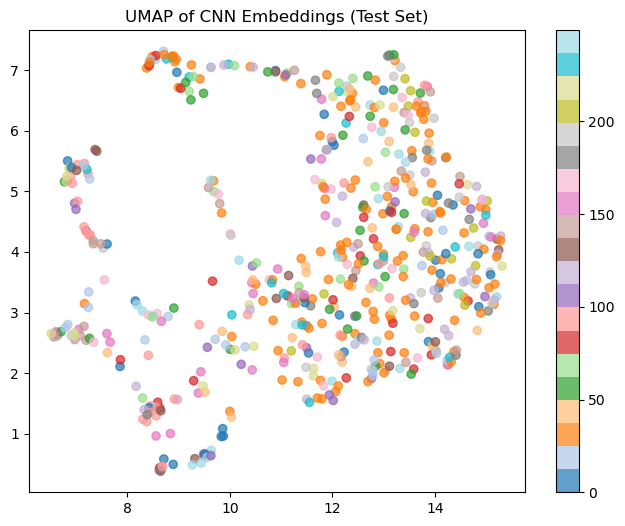

In [33]:
# Step 3: Extract CNN embeddings and do UMAP or t-SNE

# NOTICE: we remove the "!pip install umap-learn" line
# If needed, manually run "pip install umap-learn" in your terminal or command prompt.

import umap
import matplotlib.pyplot as plt
import torch

def extract_embeddings(model, data_loader):
    """
    Pass each image through the model, up to the penultimate layer (avgpool).
    Return embeddings in a NumPy array, plus integer labels.
    """
    model.eval()
    all_embs = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            
            x = model.conv1(images)
            x = model.bn1(x)
            x = model.relu(x)
            x = model.maxpool(x)

            x = model.layer1(x)
            x = model.layer2(x)
            x = model.layer3(x)
            x = model.layer4(x)

            x = model.avgpool(x)
            x = torch.flatten(x, 1)  # shape [batch_size, 512]
            
            embs = x.cpu().numpy()
            labs = labels.numpy()
            
            all_embs.append(embs)
            all_labels.append(labs)
    
    all_embs = np.concatenate(all_embs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return all_embs, all_labels

# usage
embs, labs = extract_embeddings(model, test_loader)

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
umap_embeddings = reducer.fit_transform(embs)

plt.figure(figsize=(8,6))
plt.scatter(umap_embeddings[:,0], umap_embeddings[:,1], c=labs, cmap='tab20', alpha=0.7)
plt.colorbar()
plt.title("UMAP of CNN Embeddings (Test Set)")
plt.show()


D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
D:\Anaconda\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Silhouette Score for k=2: 0.5211


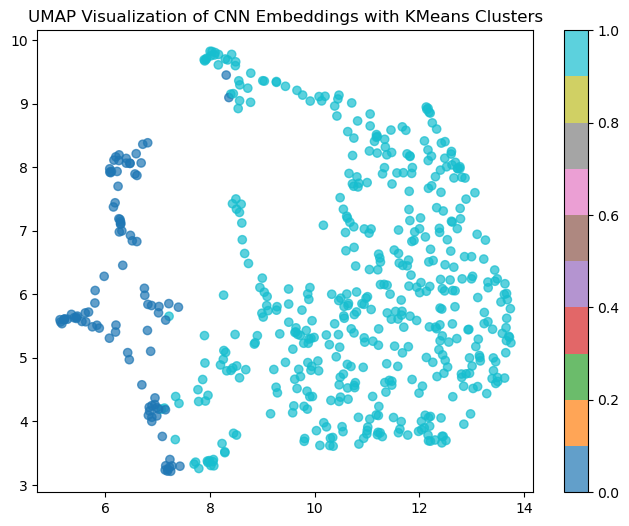

In [34]:
# Scheme 1: Using pre-trained CNN embeddings for clustering and mAP analysis

import torch
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

# Assume model and test_loader have been defined in Step 2.
# Here we use the trained CNN model (e.g., ResNet18) to extract embeddings.

def extract_cnn_embeddings(model, data_loader, device):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for images, batch_labels in data_loader:
            images = images.to(device)
            # Forward pass up to avgpool layer
            x = model.conv1(images)
            x = model.bn1(x)
            x = model.relu(x)
            x = model.maxpool(x)
            x = model.layer1(x)
            x = model.layer2(x)
            x = model.layer3(x)
            x = model.layer4(x)
            x = model.avgpool(x)
            x = torch.flatten(x, 1)  # shape: [batch_size, 512]
            embeddings.append(x.cpu().numpy())
            labels.append(batch_labels.numpy())
    embeddings = np.concatenate(embeddings, axis=0)
    labels = np.concatenate(labels, axis=0)
    return embeddings, labels

# CNN embedding
cnn_embeddings, cnn_labels = extract_cnn_embeddings(model, test_loader, device)

k = 2  
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(cnn_embeddings)

# Silhouette Score
sil_score = silhouette_score(cnn_embeddings, cluster_labels)
print(f"Silhouette Score for k={k}: {sil_score:.4f}")

umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
umap_embeddings = umap_reducer.fit_transform(cnn_embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7)
plt.colorbar()
plt.title("UMAP Visualization of CNN Embeddings with KMeans Clusters")
plt.show()


In [35]:
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Function to extract CNN embeddings from a given model and data loader
def extract_cnn_embeddings(model, data_loader, device):
    """
    Extract CNN embeddings from the model up to the avgpool layer.
    
    Args:
        model: a trained CNN model (e.g., ResNet18).
        data_loader: DataLoader for the dataset.
        device: computation device ('cuda' or 'cpu').
    
    Returns:
        embeddings: a NumPy array of shape [N, 512] (for ResNet18).
        labels: a NumPy array of corresponding ground truth labels.
    """
    model.eval()
    all_embs = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            # Forward pass up to avgpool layer
            x = model.conv1(images)
            x = model.bn1(x)
            x = model.relu(x)
            x = model.maxpool(x)
            x = model.layer1(x)
            x = model.layer2(x)
            x = model.layer3(x)
            x = model.layer4(x)
            x = model.avgpool(x)
            x = torch.flatten(x, 1)  # shape [batch_size, 512]
            all_embs.append(x.cpu().numpy())
            all_labels.append(labels.numpy())
    embeddings = np.concatenate(all_embs, axis=0)
    labels = np.concatenate(all_labels, axis=0)
    return embeddings, labels

# Assume that 'model', 'test_loader', and 'device' are already defined in previous steps.
# For example, model is a ResNet18 trained for compound classification,
# test_loader is the DataLoader for the test set, and device is 'cuda' or 'cpu'.

# Extract CNN embeddings and labels
cnn_embeddings, cnn_labels = extract_cnn_embeddings(model, test_loader, device)

# Define mAP analysis functions
def compute_average_precision(similarity_matrix, true_labels, sample_idx):
    """
    Compute average precision for one sample based on similarity ranking.
    Args:
        similarity_matrix: [N, N] array of cosine similarities.
        true_labels: [N] ground truth labels.
        sample_idx: index of the sample to compute AP.
    Returns:
        average_precision: average precision for the sample.
    """
    # Exclude self-similarity by setting the diagonal value very low.
    sim = similarity_matrix[sample_idx].copy()
    sim[sample_idx] = -1e9
    ranking = np.argsort(-sim)
    true_positive = (true_labels[ranking] == true_labels[sample_idx]).astype(np.int32)
    cumulative_true = np.cumsum(true_positive)
    precision_at_k = cumulative_true / (np.arange(1, len(true_positive)+1))
    if cumulative_true[-1] == 0:
        return 0.0
    average_precision = np.sum(precision_at_k * true_positive) / cumulative_true[-1]
    return average_precision

def compute_mAP(embeddings, true_labels):
    """
    Compute mean Average Precision (mAP) for the entire set based on cosine similarity.
    """
    sim_matrix = cosine_similarity(embeddings)
    APs = []
    for i in range(len(true_labels)):
        AP = compute_average_precision(sim_matrix, true_labels, i)
        APs.append(AP)
    mAP = np.mean(APs)
    return mAP

# Compute mAP using the extracted CNN embeddings and labels
map_score = compute_mAP(cnn_embeddings, cnn_labels)
print(f"Mean Average Precision (mAP) using CNN embeddings: {map_score:.4f}")


Mean Average Precision (mAP) using CNN embeddings: 0.1058


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from PIL import Image
import numpy as np
import math

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim=32):
        super(VAE, self).__init__()
        # Encoder: series of convolutional layers (input image assumed to be 224x224)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),  # (224 -> 112)
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # (112 -> 56)
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), # (56 -> 28)
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),# (28 -> 14)
            nn.ReLU(),
            nn.Conv2d(256, 512, 4, 2, 1),# (14 -> 7)
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(512*7*7, latent_dim)
        self.fc_logvar = nn.Linear(512*7*7, latent_dim)
        
        # Decoder: a fully-connected layer followed by transposed convolutions
        self.fc_decode = nn.Linear(latent_dim, 512*7*7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1), # (7 -> 14)
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), # (14 -> 28)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # (28 -> 56)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),   # (56 -> 112)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),    # (112 -> 224)
            nn.Sigmoid()
        )
    
    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(-1, 512, 7, 7)
        return self.decoder(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

# Define a custom Dataset for VAE (using all_data)
class ImageDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list  # list of (filepath, compound_label_str)
        self.transform = transform
        
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        fp, _ = self.data_list[idx]
        img = Image.open(fp).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

# Define data transformation: resize to 224x224 and convert to tensor
transform_vae = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

# Create dataset using all_data (all_data should be defined previously)
vae_dataset = ImageDataset(all_data, transform=transform_vae)
vae_loader = DataLoader(vae_dataset, batch_size=16, shuffle=True)

# Instantiate the VAE model
latent_dim = 32
vae_model = VAE(latent_dim=latent_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae_model = vae_model.to(device)

optimizer = optim.Adam(vae_model.parameters(), lr=1e-4)

# Define the VAE loss function
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Train the VAE (simple version)
num_epochs = 5
vae_model.train()
for epoch in range(num_epochs):
    train_loss = 0.0
    for images in vae_loader:
        images = images.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = vae_model(images)
        loss = vae_loss(recon, images, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_loss = train_loss / len(vae_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

# Extract VAE latent variables (mu) as embeddings
vae_model.eval()
all_mu = []
with torch.no_grad():
    for images in vae_loader:
        images = images.to(device)
        _, mu, _ = vae_model(images)
        all_mu.append(mu.cpu().numpy())
vae_embeddings = np.concatenate(all_mu, axis=0)
print("VAE embeddings shape:", vae_embeddings.shape)


Epoch 1/5, Loss: 47464.5235
Epoch 2/5, Loss: 29513.2591
Epoch 3/5, Loss: 29254.7394
Epoch 4/5, Loss: 28975.7725
Epoch 5/5, Loss: 28724.9129
VAE embeddings shape: (2867, 32)


Epoch 1/5, Loss: 41680.2966
Epoch 2/5, Loss: 29646.5489
Epoch 3/5, Loss: 29301.2275
Epoch 4/5, Loss: 29153.4586
Epoch 5/5, Loss: 28869.5157
VAE embeddings shape: (2867, 32)
VAE: Silhouette Score for k=2: 0.1423


D:\Anaconda\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


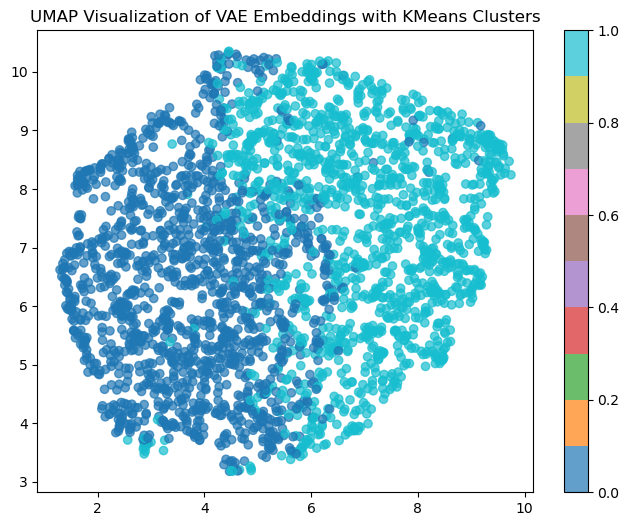

Mean Average Precision (mAP) using VAE embeddings: 0.0365


In [37]:
# Scheme 2: VAE for image embedding, clustering, and mAP analysis (using all 2867 images)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image
import numpy as np
import math

# ------------------------------
# Define the VAE model
# ------------------------------
class VAE(nn.Module):
    def __init__(self, latent_dim=32):
        super(VAE, self).__init__()
        # Encoder: series of convolutional layers (input assumed to be 224x224)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),  # (224 -> 112)
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # (112 -> 56)
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), # (56 -> 28)
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),# (28 -> 14)
            nn.ReLU(),
            nn.Conv2d(256, 512, 4, 2, 1),# (14 -> 7)
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(512*7*7, latent_dim)
        self.fc_logvar = nn.Linear(512*7*7, latent_dim)
        
        # Decoder: fully connected layer then transposed convolutions
        self.fc_decode = nn.Linear(latent_dim, 512*7*7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1), # (7 -> 14)
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), # (14 -> 28)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # (28 -> 56)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),   # (56 -> 112)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),    # (112 -> 224)
            nn.Sigmoid()
        )
    
    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(-1, 512, 7, 7)
        return self.decoder(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

# ------------------------------
# Define Dataset for VAE (using all_data)
# ------------------------------
class ImageDataset(Dataset):
    def __init__(self, data_list, transform=None):
        """
        data_list: list of (filepath, compound_label_str)
        transform: torchvision transforms (e.g., Resize and ToTensor)
        """
        self.data_list = data_list
        self.transform = transform
        
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        fp, _ = self.data_list[idx]
        img = Image.open(fp).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

# ------------------------------
# Data transformation and DataLoader
# ------------------------------
transform_vae = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

# Assume all_data is a list of (filepath, compound_label_str) for all 2867 images
vae_dataset = ImageDataset(all_data, transform=transform_vae)
vae_loader = DataLoader(vae_dataset, batch_size=16, shuffle=True)

# ------------------------------
# Instantiate and train VAE
# ------------------------------
latent_dim = 32
vae_model = VAE(latent_dim=latent_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae_model = vae_model.to(device)

optimizer = optim.Adam(vae_model.parameters(), lr=1e-4)

def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss: binary cross entropy summed over all pixels
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    # Kullback-Leibler divergence loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

num_epochs = 5
vae_model.train()
for epoch in range(num_epochs):
    train_loss = 0.0
    for images in vae_loader:
        images = images.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = vae_model(images)
        loss = vae_loss(recon, images, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_loss = train_loss / len(vae_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

# ------------------------------
# Extract VAE embeddings (use mu as embedding)
# ------------------------------
vae_model.eval()
all_mu = []
with torch.no_grad():
    for images in vae_loader:
        images = images.to(device)
        _, mu, _ = vae_model(images)
        all_mu.append(mu.cpu().numpy())
vae_embeddings = np.concatenate(all_mu, axis=0)
print("VAE embeddings shape:", vae_embeddings.shape)  # Expected shape: (2867, 32)

# ------------------------------
# Prepare true labels for mAP analysis
# ------------------------------
# Define compound_label_to_idx based on all_data if not defined
compound_labels = sorted(set([lab_str for (_, lab_str) in all_data]))
compound_label_to_idx = {lab: i for i, lab in enumerate(compound_labels)}

all_labels = []
for _, compound_str in all_data:
    all_labels.append(compound_label_to_idx[compound_str])
all_labels = np.array(all_labels)

# ------------------------------
# Clustering with VAE embeddings and mAP analysis
# ------------------------------
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

# Clustering using KMeans with k=2 clusters as an example
k = 2
kmeans_vae = KMeans(n_clusters=k, random_state=42)
vae_cluster_labels = kmeans_vae.fit_predict(vae_embeddings)

# Calculate Silhouette Score
sil_score_vae = silhouette_score(vae_embeddings, vae_cluster_labels)
print(f"VAE: Silhouette Score for k={k}: {sil_score_vae:.4f}")

# Visualize embeddings with UMAP
import umap
import matplotlib.pyplot as plt

umap_reducer_vae = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
umap_embeddings_vae = umap_reducer_vae.fit_transform(vae_embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(umap_embeddings_vae[:, 0], umap_embeddings_vae[:, 1], c=vae_cluster_labels, cmap='tab10', alpha=0.7)
plt.colorbar()
plt.title("UMAP Visualization of VAE Embeddings with KMeans Clusters")
plt.show()

# ------------------------------
# mAP Analysis Functions
# ------------------------------
def compute_average_precision(similarity_matrix, true_labels, sample_idx):
    """
    Compute average precision for one sample based on similarity ranking.
    Args:
        similarity_matrix: [N, N] array of cosine similarities.
        true_labels: [N] array of ground truth labels.
        sample_idx: index of the sample to compute AP.
    Returns:
        average_precision: average precision for the sample.
    """
    sim = similarity_matrix[sample_idx].copy()
    sim[sample_idx] = -1e9  # exclude self-similarity
    ranking = np.argsort(-sim)
    true_positive = (true_labels[ranking] == true_labels[sample_idx]).astype(np.int32)
    cumulative_true = np.cumsum(true_positive)
    precision_at_k = cumulative_true / (np.arange(1, len(true_positive)+1))
    if cumulative_true[-1] == 0:
        return 0.0
    average_precision = np.sum(precision_at_k * true_positive) / cumulative_true[-1]
    return average_precision

def compute_mAP(embeddings, true_labels):
    """
    Compute mean Average Precision (mAP) for the entire set based on cosine similarity.
    """
    sim_matrix = cosine_similarity(embeddings)
    APs = []
    for i in range(len(true_labels)):
        AP = compute_average_precision(sim_matrix, true_labels, i)
        APs.append(AP)
    mAP = np.mean(APs)
    return mAP

map_score_vae = compute_mAP(vae_embeddings, all_labels)
print(f"Mean Average Precision (mAP) using VAE embeddings: {map_score_vae:.4f}")


D:\Anaconda\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


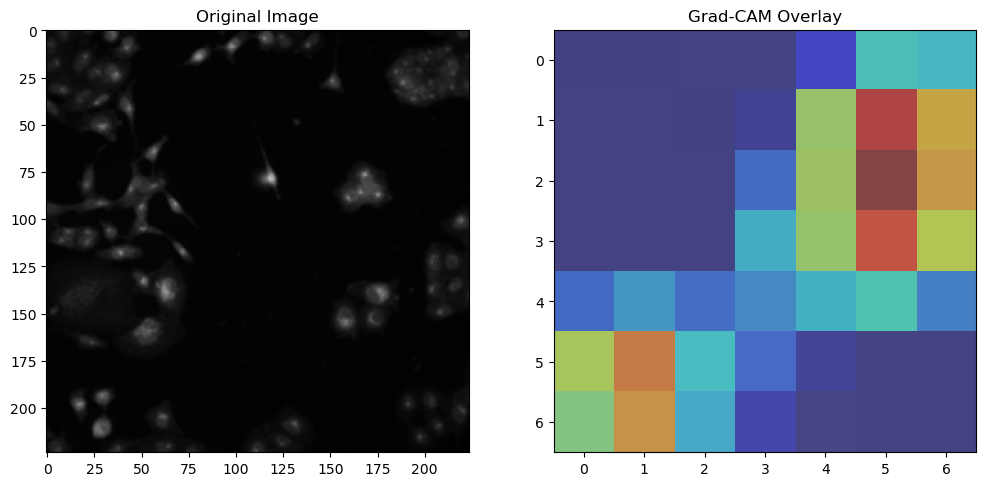

In [38]:
# Step 5: Grad-CAM or CAM-like visualization

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Define GradCam class
class GradCam:
    def __init__(self, model, target_layer):
        """
        Initialize with a model and a target layer to extract activation and gradients.
        """
        self.model = model
        self.target_layer = target_layer
        self.grad = None
        self.activation = None
        
        # Register hooks to capture forward activations and backward gradients.
        self.target_layer.register_forward_hook(self.forward_hook)
        # Note: register_backward_hook is deprecated in some versions;
        # if available, consider using register_full_backward_hook.
        self.target_layer.register_backward_hook(self.backward_hook)
    
    def forward_hook(self, module, input, output):
        """
        Hook to capture forward activation.
        """
        self.activation = output
    
    def backward_hook(self, module, grad_in, grad_out):
        """
        Hook to capture backward gradients.
        """
        self.grad = grad_out[0]  # Get gradient with respect to the activation
    
    def generate_cam(self, input_tensor, class_idx):
        """
        Generate the Class Activation Map for a given input and target class.
        Args:
            input_tensor: a tensor of shape [1, 3, H, W]
            class_idx: target class index (int)
        Returns:
            cam: numpy array of shape [H', W'] with values normalized to [0, 1]
        """
        # Forward pass
        output = self.model(input_tensor)  # shape [1, num_classes]
        
        # Create a one-hot encoding for the target class
        one_hot = torch.zeros_like(output)
        one_hot[0, class_idx] = 1.0
        
        # Backward pass with respect to the target class
        output.backward(gradient=one_hot)
        
        # Calculate the mean of the gradients over the spatial dimensions
        grad_mean = torch.mean(self.grad, dim=[0, 2, 3], keepdim=True)  # shape [1, channels, 1, 1]
        
        # Compute the weighted sum of activations
        cam = F.relu(torch.sum(grad_mean * self.activation, dim=1, keepdim=True))  # shape [1, 1, H', W']
        
        # Detach the result, move to CPU and convert to numpy array
        cam = cam[0, 0].detach().cpu().numpy()
        
        # Normalize the CAM to [0, 1]
        cam -= cam.min()
        cam /= (cam.max() + 1e-5)
        return cam

target_layer = model.layer4[-1]  

# Create an instance of GradCam with the model and target layer.
gradcam = GradCam(model, target_layer)

# Get a batch of images from the test loader.
sample_img_batch, sample_label_batch = next(iter(test_loader))

# Pick the first image in the batch and prepare it.
sample_img = sample_img_batch[0].unsqueeze(0).to(device)  # shape [1, 3, H, W]

# Perform a forward pass to obtain the prediction.
pred_logit = model(sample_img)
pred_class = pred_logit.argmax(dim=1).item()

# Generate the CAM for the predicted class.
cam_map = gradcam.generate_cam(sample_img, pred_class)

# Visualize the original image and the Grad-CAM overlay.
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
# Convert tensor image from CHW to HWC and to numpy array.
img_np = sample_img_batch[0].permute(1, 2, 0).numpy()
plt.imshow(img_np)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(img_np, alpha=0.5)
plt.imshow(cam_map, cmap='jet', alpha=0.5)
plt.title("Grad-CAM Overlay")
plt.show()


Processed 574 images for Grad-CAM analysis.


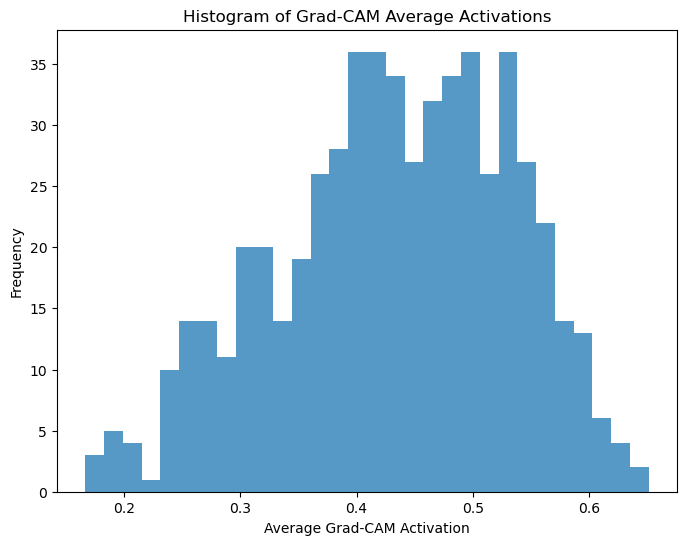

In [39]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Define the GradCam class (same as before)
class GradCam:
    def __init__(self, model, target_layer):
        """
        Initialize with a model and a target layer to extract activations and gradients.
        """
        self.model = model
        self.target_layer = target_layer
        self.grad = None
        self.activation = None

        # Register hooks to capture forward activations and backward gradients.
        self.target_layer.register_forward_hook(self.forward_hook)
        # Note: register_backward_hook is deprecated in some versions; consider using register_full_backward_hook.
        self.target_layer.register_backward_hook(self.backward_hook)
    
    def forward_hook(self, module, input, output):
        """
        Hook to capture forward activation.
        """
        self.activation = output

    def backward_hook(self, module, grad_in, grad_out):
        """
        Hook to capture backward gradients.
        """
        self.grad = grad_out[0]  # Get gradient with respect to the activation

    def generate_cam(self, input_tensor, class_idx):
        """
        Generate the Class Activation Map for a given input and target class.
        
        Args:
            input_tensor: a tensor of shape [1, 3, H, W]
            class_idx: target class index (int)
        
        Returns:
            cam: numpy array of shape [H', W'] with values normalized to [0, 1]
        """
        # Forward pass
        output = self.model(input_tensor)  # shape [1, num_classes]
        
        # Create a one-hot encoding for the target class
        one_hot = torch.zeros_like(output)
        one_hot[0, class_idx] = 1.0
        
        # Backward pass with respect to the target class (do not use torch.no_grad())
        self.model.zero_grad()
        output.backward(gradient=one_hot)
        
        # Calculate the mean of the gradients over the spatial dimensions
        grad_mean = torch.mean(self.grad, dim=[0, 2, 3], keepdim=True)  # shape [1, channels, 1, 1]
        
        # Compute the weighted sum of activations
        cam = F.relu(torch.sum(grad_mean * self.activation, dim=1, keepdim=True))  # shape [1, 1, H', W']
        
        # Detach, move to CPU and convert to numpy array
        cam = cam[0, 0].detach().cpu().numpy()
        
        # Normalize the CAM to [0, 1]
        cam -= cam.min()
        cam /= (cam.max() + 1e-5)
        return cam

# Function to compute Grad-CAM for all images in a dataset (without torch.no_grad)
def compute_gradcam_for_dataset(model, data_loader, gradcam, device):
    """
    Compute Grad-CAM for all images in the data_loader.
    
    Returns:
        gradcam_maps: list of numpy arrays, each is the Grad-CAM map for one image.
        predictions: list of predicted class indices.
        true_labels: list of true labels.
    """
    model.eval()
    gradcam_maps = []
    predictions = []
    true_labels = []
    
    # Do not wrap in torch.no_grad() because we need gradients for backward.
    for images, labels in data_loader:
        # Process each image in the batch individually.
        for i in range(images.size(0)):
            img = images[i].unsqueeze(0).to(device)  # shape [1, 3, H, W]
            # Forward pass to get prediction
            output = model(img)
            pred_class = output.argmax(dim=1).item()
            # Generate Grad-CAM for the predicted class
            cam_map = gradcam.generate_cam(img, pred_class)
            gradcam_maps.append(cam_map)
            predictions.append(pred_class)
            true_labels.append(labels[i].item())
    return gradcam_maps, predictions, true_labels

# Example usage:
# Ensure 'model', 'device', and 'test_loader' are defined from previous steps.
# Instantiate GradCam with the target layer (e.g., model.layer4[-1] for ResNet18)
target_layer = model.layer4[-1]
gradcam = GradCam(model, target_layer)

# Compute Grad-CAM for all images in the test loader
gradcam_maps, preds, true_labels = compute_gradcam_for_dataset(model, test_loader, gradcam, device)
print(f"Processed {len(gradcam_maps)} images for Grad-CAM analysis.")

# For example, compute average activation value of each Grad-CAM map as a simple quantitative metric:
avg_activations = [np.mean(cam) for cam in gradcam_maps]

# Plot histogram of average activations
plt.figure(figsize=(8, 6))
plt.hist(avg_activations, bins=30, alpha=0.75)
plt.xlabel("Average Grad-CAM Activation")
plt.ylabel("Frequency")
plt.title("Histogram of Grad-CAM Average Activations")
plt.show()


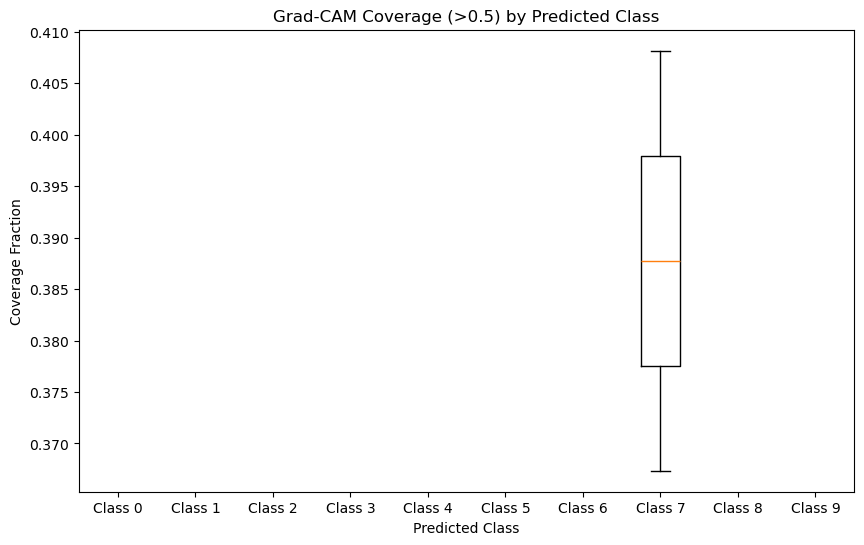

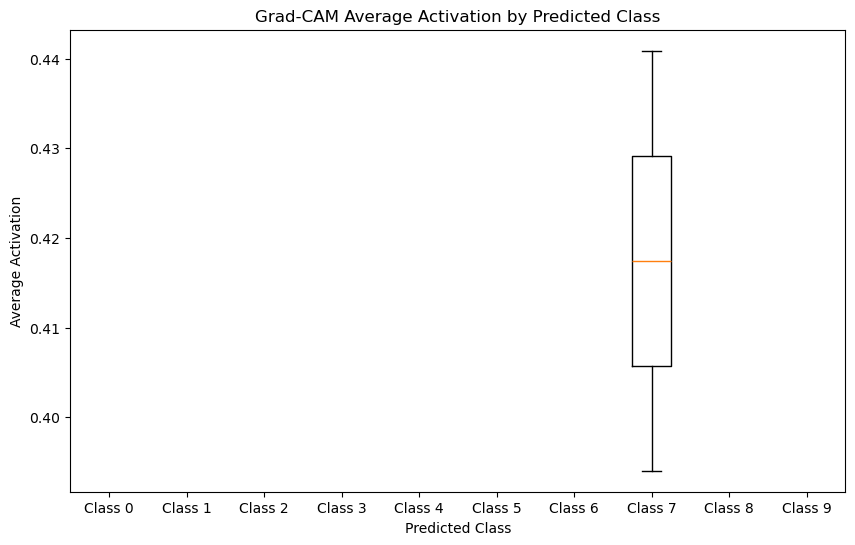

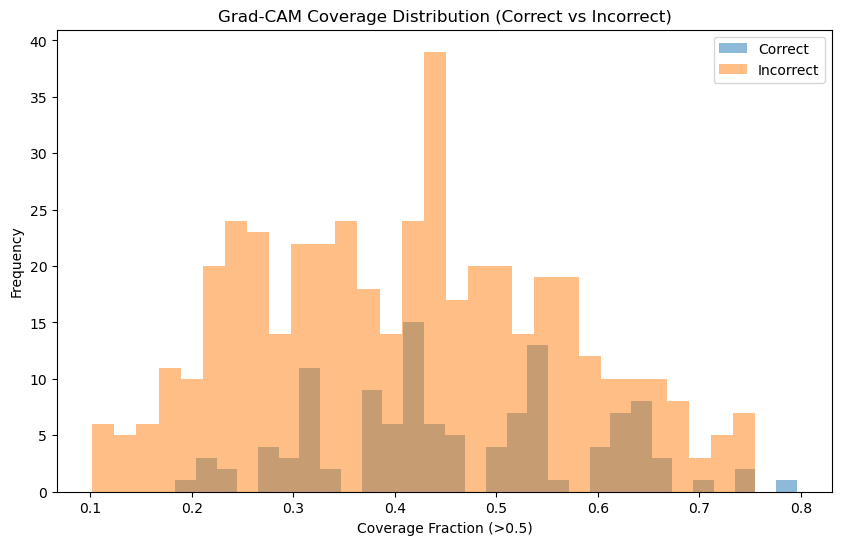

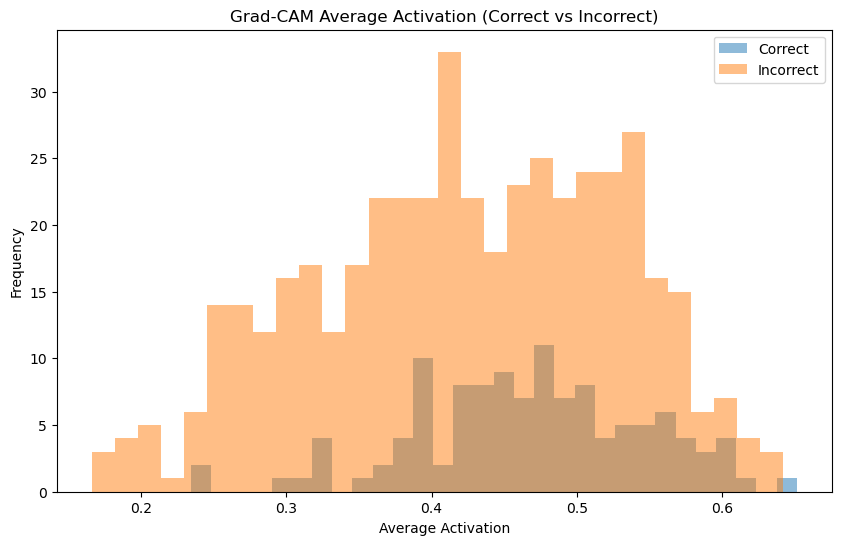

In [40]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_gradcam_deeply(gradcam_maps, preds, true_labels, threshold=0.5):
    """
    Perform deeper analysis on Grad-CAM results.
    
    Args:
        gradcam_maps: list of Grad-CAM heatmaps (numpy arrays), each shape [H, W].
        preds: list of predicted classes (ints), same length as gradcam_maps.
        true_labels: list of true labels (ints), same length as gradcam_maps.
        threshold: float in [0,1], coverage threshold for CAM activation.
    
    Returns:
        coverage_per_sample: list of coverage fractions for each image.
        avg_act_per_sample: list of average Grad-CAM activations for each image.
    """
    num_samples = len(gradcam_maps)
    coverage_per_sample = []
    avg_act_per_sample = []
    
    for i in range(num_samples):
        cam = gradcam_maps[i]
        # Compute average Grad-CAM activation
        avg_act = np.mean(cam)
        avg_act_per_sample.append(avg_act)
        
        # Compute coverage fraction (pixels above threshold)
        coverage = np.mean(cam > threshold)
        coverage_per_sample.append(coverage)
    
    return coverage_per_sample, avg_act_per_sample

def plot_classwise_stats(coverage_per_sample, avg_act_per_sample, preds, true_labels, num_classes=10):
    """
    Plot distribution of coverage and average activation for each class,
    and compare correct vs incorrect predictions.
    
    Args:
        coverage_per_sample: list of coverage fractions (float).
        avg_act_per_sample: list of average activations (float).
        preds: list of predicted classes.
        true_labels: list of true labels.
        num_classes: total number of classes (for demonstration).
    """
    # Separate correct vs incorrect
    correctness = [int(p == t) for p, t in zip(preds, true_labels)]
    
    # Build structures to hold coverage and avg activation by class
    coverage_by_class = [[] for _ in range(num_classes)]
    avg_act_by_class = [[] for _ in range(num_classes)]
    
    for i in range(len(preds)):
        c = preds[i]
        if c < num_classes:  # ensure valid
            coverage_by_class[c].append(coverage_per_sample[i])
            avg_act_by_class[c].append(avg_act_per_sample[i])
    
    # Plot coverage distribution by predicted class (boxplot)
    plt.figure(figsize=(10,6))
    plt.boxplot(coverage_by_class, labels=[f"Class {i}" for i in range(num_classes)], showfliers=False)
    plt.title("Grad-CAM Coverage (>0.5) by Predicted Class")
    plt.xlabel("Predicted Class")
    plt.ylabel("Coverage Fraction")
    plt.show()
    
    # Plot average activation distribution by predicted class (boxplot)
    plt.figure(figsize=(10,6))
    plt.boxplot(avg_act_by_class, labels=[f"Class {i}" for i in range(num_classes)], showfliers=False)
    plt.title("Grad-CAM Average Activation by Predicted Class")
    plt.xlabel("Predicted Class")
    plt.ylabel("Average Activation")
    plt.show()
    
    # Compare correct vs incorrect predictions (histograms)
    correct_cov = []
    incorrect_cov = []
    correct_act = []
    incorrect_act = []
    
    for i in range(len(preds)):
        if correctness[i] == 1:
            correct_cov.append(coverage_per_sample[i])
            correct_act.append(avg_act_per_sample[i])
        else:
            incorrect_cov.append(coverage_per_sample[i])
            incorrect_act.append(avg_act_per_sample[i])
    
    # Hist comparison for coverage
    plt.figure(figsize=(10,6))
    plt.hist(correct_cov, bins=30, alpha=0.5, label="Correct")
    plt.hist(incorrect_cov, bins=30, alpha=0.5, label="Incorrect")
    plt.title("Grad-CAM Coverage Distribution (Correct vs Incorrect)")
    plt.xlabel("Coverage Fraction (>0.5)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    
    # Hist comparison for average activation
    plt.figure(figsize=(10,6))
    plt.hist(correct_act, bins=30, alpha=0.5, label="Correct")
    plt.hist(incorrect_act, bins=30, alpha=0.5, label="Incorrect")
    plt.title("Grad-CAM Average Activation (Correct vs Incorrect)")
    plt.xlabel("Average Activation")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# Example usage after obtaining gradcam_maps, preds, true_labels from compute_gradcam_for_dataset:
threshold = 0.5
coverage_per_sample, avg_act_per_sample = analyze_gradcam_deeply(
    gradcam_maps, preds, true_labels, threshold=threshold
)

# Suppose we have num_classes = 10 (change as appropriate)
plot_classwise_stats(coverage_per_sample, avg_act_per_sample, preds, true_labels, num_classes=10)


In [41]:
import os
import numpy as np
from PIL import Image
import math
from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import torchvision.transforms as T

# ------------------------------
# Helper function: extract first 9 characters (prefix) from a filename
# ------------------------------
def get_prefix9(fname):
    """
    Extract the first 9 characters from the filename.
    """
    return fname[:9]

# ------------------------------
# Read CellProfiler features (df2) and build a dictionary mapping prefix to selected features
# ------------------------------
# Assume CellProfiler features CSV is stored as "MyExpt_Image.csv"
df2 = pd.read_csv("MyExpt_Image.csv")
# Select important features based on biological interpretation:
#   - Count_IdentifyPrimaryObjects: cell count
#   - Texture_Contrast_DNA_3_00_256: texture contrast
#   - Texture_Entropy_DNA_3_00_256: texture entropy
selected_columns = ["Count_IdentifyPrimaryObjects", "Texture_Contrast_DNA_3_00_256", "Texture_Entropy_DNA_3_00_256"]

# Build a dictionary: key = prefix (first 9 characters of FileName_DNA), value = numpy array of selected features
cp_feat_dict = {}
for idx, row in df2.iterrows():
    if all(col in row for col in selected_columns):
        prefix = row["FileName_DNA"][:9]
        features = row[selected_columns].values.astype(float)  # shape: (3,)
        cp_feat_dict[prefix] = features
    else:
        print(f"Missing selected columns in row {idx}")

# ------------------------------
# The original aggregated mapping is assumed to be built as in Step 0:
# 'all_data' is a list of tuples: (filepath, compound_label_str)
# 'label_to_idx' is a dictionary mapping compound labels to integers.
# 'skf' and 'numeric_labels' are defined.
# ------------------------------

# ------------------------------
# Define image transformation for feature extraction (resize to 64x64)
# ------------------------------
transform_resize = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor(),
])

# ------------------------------
# Functions for Incremental PCA on image features
# ------------------------------
def incremental_pca_fit(X_paths, n_components=100, batch_size=256):
    """
    Fit an IncrementalPCA model on the flattened image features.
    """
    ipca = IncrementalPCA(n_components=n_components)
    num_imgs = len(X_paths)
    num_batches = math.ceil(num_imgs / batch_size)
    idx_start = 0
    for b in range(num_batches):
        batch_paths = X_paths[idx_start:idx_start+batch_size]
        idx_start += batch_size
        batch_data_list = []
        for fp in batch_paths:
            img = Image.open(fp).convert('RGB')
            img_t = transform_resize(img)  # shape: [3, 64, 64]
            img_np = img_t.numpy().ravel()  # flatten vector
            batch_data_list.append(img_np)
        if len(batch_data_list) == 0:
            continue
        batch_data = np.stack(batch_data_list, axis=0)
        ipca.partial_fit(batch_data)
    return ipca

def transform_with_ipca(X_paths, ipca, batch_size=256):
    """
    Transform image features using the fitted IncrementalPCA model.
    """
    data_proj_list = []
    idx_start = 0
    num_imgs = len(X_paths)
    num_batches = math.ceil(num_imgs / batch_size)
    for b in range(num_batches):
        batch_paths = X_paths[idx_start:idx_start+batch_size]
        idx_start += batch_size
        batch_data_list = []
        for fp in batch_paths:
            img = Image.open(fp).convert('RGB')
            img_t = transform_resize(img)
            img_np = img_t.numpy().ravel()
            batch_data_list.append(img_np)
        if len(batch_data_list) == 0:
            continue
        batch_data = np.stack(batch_data_list, axis=0)
        batch_proj = ipca.transform(batch_data)
        data_proj_list.append(batch_proj)
    X_proj = np.concatenate(data_proj_list, axis=0)
    return X_proj

# ------------------------------
# Function to get CellProfiler features for a given file path using cp_feat_dict
# ------------------------------
def get_cp_features(fp):
    """
    Given a file path, extract its prefix and return the corresponding CellProfiler features.
    If not found, return a zero vector.
    """
    prefix = get_prefix9(os.path.basename(fp))
    if prefix in cp_feat_dict:
        return cp_feat_dict[prefix]
    else:
        return np.zeros(len(selected_columns))

# ------------------------------
# 5-Fold training with feature fusion (image features from PCA + CellProfiler features)
# ------------------------------
def run_5fold_ipca_logreg_fused(all_data, label_to_idx, skf, numeric_labels, 
                                n_components=100, batch_size=256):
    """
    For each fold:
      1) Split train/test based on all_data.
      2) Extract image features via IncrementalPCA.
      3) Standardize image features.
      4) Extract CellProfiler features for each sample and standardize them.
      5) Concatenate image features and CP features to form fused features.
      6) Train Logistic Regression (max_iter=2000) on fused features and evaluate accuracy.
    """
    fold_idx = 1
    for train_index, test_index in skf.split(np.zeros(len(numeric_labels)), numeric_labels):
        print(f"\n=== Fold {fold_idx} ===")
        train_subset = [all_data[i] for i in train_index]
        test_subset  = [all_data[i] for i in test_index]
        
        # Separate file paths and labels for training and testing
        X_train_paths = [fp for (fp, _) in train_subset]
        y_train = np.array([label_to_idx[lab_str] for (_, lab_str) in train_subset])
        X_test_paths = [fp for (fp, _) in test_subset]
        y_test = np.array([label_to_idx[lab_str] for (_, lab_str) in test_subset])
        
        print("Train data count:", len(X_train_paths))
        print("Test data count:", len(X_test_paths))
        
        # Step 1: Fit IncrementalPCA on training image features
        ipca = incremental_pca_fit(X_train_paths, n_components=n_components, batch_size=batch_size)
        X_train_img = transform_with_ipca(X_train_paths, ipca, batch_size=batch_size)
        X_test_img = transform_with_ipca(X_test_paths, ipca, batch_size=batch_size)
        
        print("Train image features shape after PCA:", X_train_img.shape)
        print("Test image features shape after PCA:", X_test_img.shape)
        
        # Standardize the PCA image features
        scaler_img = StandardScaler()
        X_train_img_scaled = scaler_img.fit_transform(X_train_img)
        X_test_img_scaled = scaler_img.transform(X_test_img)
        
        # Step 2: Extract CellProfiler features for each sample and stack them
        X_train_cp = np.stack([get_cp_features(fp) for fp in X_train_paths], axis=0)
        X_test_cp = np.stack([get_cp_features(fp) for fp in X_test_paths], axis=0)
        
        # Standardize the CP features
        scaler_cp = StandardScaler()
        X_train_cp_scaled = scaler_cp.fit_transform(X_train_cp)
        X_test_cp_scaled = scaler_cp.transform(X_test_cp)
        
        # Step 3: Concatenate the standardized image features with standardized CP features
        X_train_fused = np.concatenate([X_train_img_scaled, X_train_cp_scaled], axis=1)
        X_test_fused = np.concatenate([X_test_img_scaled, X_test_cp_scaled], axis=1)
        
        print("Train fused features shape:", X_train_fused.shape)
        print("Test fused features shape:", X_test_fused.shape)
        
        # Step 4: Train Logistic Regression on fused features with increased max_iter
        clf = LogisticRegression(max_iter=2000)
        clf.fit(X_train_fused, y_train)
        y_pred = clf.predict(X_test_fused)
        
        acc = accuracy_score(y_test, y_pred)
        print(f"Fold {fold_idx} Accuracy: {acc:.4f}")
        
        fold_idx += 1

# Run the fused feature experiment
run_5fold_ipca_logreg_fused(all_data, label_to_idx, skf, numeric_labels, 
                            n_components=100, batch_size=256)



=== Fold 1 ===
Train data count: 2293
Test data count: 574
Train image features shape after PCA: (2293, 100)
Test image features shape after PCA: (574, 100)
Train fused features shape: (2293, 103)
Test fused features shape: (574, 103)
Fold 1 Accuracy: 0.1638

=== Fold 2 ===
Train data count: 2293
Test data count: 574
Train image features shape after PCA: (2293, 100)
Test image features shape after PCA: (574, 100)
Train fused features shape: (2293, 103)
Test fused features shape: (574, 103)
Fold 2 Accuracy: 0.1307

=== Fold 3 ===
Train data count: 2294
Test data count: 573
Train image features shape after PCA: (2294, 100)
Test image features shape after PCA: (573, 100)
Train fused features shape: (2294, 103)
Test fused features shape: (573, 103)
Fold 3 Accuracy: 0.1658

=== Fold 4 ===
Train data count: 2294
Test data count: 573
Train image features shape after PCA: (2294, 100)
Test image features shape after PCA: (573, 100)
Train fused features shape: (2294, 103)
Test fused features sh

In [42]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torchvision.models as models

# ------------------------------
# Assume that 'all_data' is a list of tuples (filepath, compound_label_str)
# and 'label_to_idx' is a dictionary mapping compound labels to integers.
# Also assume that cp_feat_dict and get_cp_features(fp) are defined from previous steps.
# For example, cp_feat_dict maps file prefix (first 9 characters) to a numpy array of selected CP features.
# ------------------------------

# Example get_cp_features function (from previous step)
def get_prefix9(fname):
    """Extract the first 9 characters from the filename."""
    return fname[:9]

def get_cp_features(fp):
    """
    Given a file path, extract its prefix and return the corresponding
    CellProfiler features from cp_feat_dict.
    If not found, return a zero vector of length 3.
    """
    prefix = get_prefix9(os.path.basename(fp))
    if prefix in cp_feat_dict:
        return cp_feat_dict[prefix]
    else:
        return np.zeros(3)

# ------------------------------
# Define a multi-input dataset that returns image, CP features, and label
# ------------------------------
class MultiInputDataset(Dataset):
    """
    A dataset that returns:
        - an image (transformed),
        - the corresponding CellProfiler features (as a numpy array),
        - and the label (as an integer).
    """
    def __init__(self, data_list, label_to_idx, transform=None):
        """
        Args:
            data_list: list of tuples (filepath, compound_label_str)
            label_to_idx: dictionary mapping compound labels to integers
            transform: torchvision transforms to apply to the image
        """
        self.data_list = data_list
        self.label_to_idx = label_to_idx
        self.transform = transform
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        fp, lab_str = self.data_list[idx]
        # Load image and apply transform
        img = Image.open(fp).convert('RGB')
        if self.transform:
            img = self.transform(img)
        # Get CellProfiler features for the image (as numpy array)
        cp_features = get_cp_features(fp)  # shape (3,)
        # Convert CP features to tensor (float)
        cp_features = torch.tensor(cp_features, dtype=torch.float32)
        # Get label as integer
        label = self.label_to_idx[lab_str]
        return img, cp_features, label

# ------------------------------
# Define transformations for images (for training and testing)
# ------------------------------
transform_train = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
])

transform_test = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
])

# Create dataset using all_data
all_dataset = MultiInputDataset(all_data, label_to_idx, transform=transform_train)

# Split dataset into train and test sets (80/20 split)
train_size = int(0.8 * len(all_dataset))
test_size = len(all_dataset) - train_size
train_dataset, test_dataset = random_split(all_dataset, [train_size, test_size])

# Update transforms for train and test subsets
train_dataset.dataset.transform = transform_train
test_dataset.dataset.transform  = transform_test

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

# ------------------------------
# Define a multi-input model that fuses CNN features and CellProfiler features
# ------------------------------
class MultiInputModel(nn.Module):
    def __init__(self, num_classes, cp_feature_dim=3):
        """
        Initialize with a pretrained ResNet18 backbone.
        The network extracts image features, then concatenates them with 
        the CellProfiler features, and feeds the fused features to a classifier.
        
        Args:
            num_classes: number of output classes.
            cp_feature_dim: dimension of CellProfiler features.
        """
        super(MultiInputModel, self).__init__()
        # Load pretrained ResNet18 and remove the final fc layer
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()  # Backbone now outputs a feature vector of dimension in_features
        
        # Define a classifier that takes concatenated features (image + CP features)
        fused_dim = in_features + cp_feature_dim
        self.classifier = nn.Linear(fused_dim, num_classes)
    
    def forward(self, x, cp_features):
        """
        Args:
            x: image tensor, shape [batch_size, 3, 224, 224]
            cp_features: tensor of CellProfiler features, shape [batch_size, cp_feature_dim]
        Returns:
            logits: output predictions, shape [batch_size, num_classes]
        """
        # Extract image features using the backbone (ResNet18)
        img_features = self.backbone(x)  # shape [batch_size, in_features]
        # Concatenate image features with CellProfiler features along the feature dimension
        fused_features = torch.cat((img_features, cp_features), dim=1)
        # Compute logits using the classifier
        logits = self.classifier(fused_features)
        return logits

# ------------------------------
# Instantiate the model, optimizer, and loss function
# ------------------------------
num_classes = len(label_to_idx)
model = MultiInputModel(num_classes=num_classes, cp_feature_dim=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# ------------------------------
# Define evaluation and training functions
# ------------------------------
def evaluate_model(model, criterion, data_loader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, cp_features, labels in data_loader:
            images = images.to(device)
            cp_features = cp_features.to(device)
            labels = labels.to(device)
            outputs = model(images, cp_features)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    avg_loss = running_loss / total
    acc = 100.0 * correct / total
    return avg_loss, acc

def train_model(model, criterion, optimizer, train_loader, val_loader, device, epochs=3):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, cp_features, labels in train_loader:
            images = images.to(device)
            cp_features = cp_features.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images, cp_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {epoch_loss:.4f}")
        val_loss, val_acc = evaluate_model(model, criterion, val_loader, device)
        print(f"  Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.2f}%")

# ------------------------------
# Train the multi-input model
# ------------------------------
train_model(model, criterion, optimizer, train_loader, test_loader, device, epochs=3)


Epoch [1/3] - Train Loss: 14.0784
  Validation Loss: 10.8709, Validation Acc: 1.39%
Epoch [2/3] - Train Loss: 6.9200
  Validation Loss: 5.9004, Validation Acc: 19.34%
Epoch [3/3] - Train Loss: 5.6099
  Validation Loss: 5.2376, Validation Acc: 18.47%


Fused features shape: (574, 515)
Fused Features: Silhouette Score for k=2: 0.5036


D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
D:\Anaconda\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


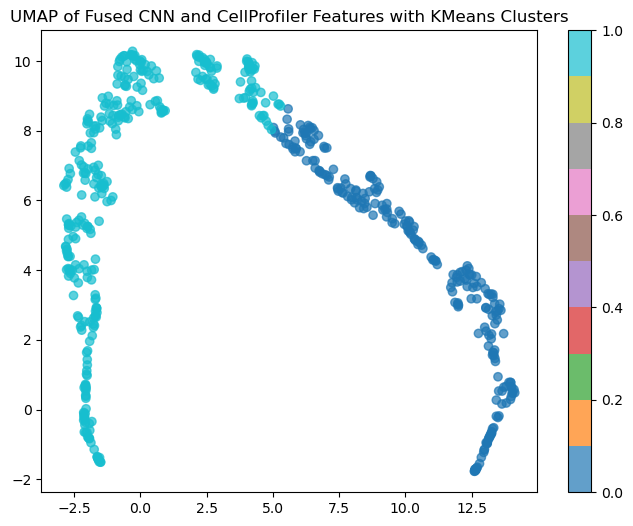

Mean Average Precision (mAP) using fused features: 0.0811


In [43]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

# ------------------------------------------------------------------------------
# Modified function to extract CNN embeddings from a MultiInputModel.
# In our MultiInputModel, the image feature extractor is defined as model.backbone.
# We ignore the CP features from the dataset and only use the image part.
# ------------------------------------------------------------------------------
def extract_cnn_embeddings(model, data_loader, device):
    """
    Extract CNN embeddings from the model's backbone.
    
    Args:
        model: a trained MultiInputModel.
        data_loader: DataLoader for the dataset.
        device: computation device ('cuda' or 'cpu').
    
    Returns:
        embeddings: a NumPy array of shape [N, 512] (for ResNet18 backbone).
        labels: a NumPy array of corresponding ground truth labels.
    """
    model.eval()
    all_embs = []
    all_labels = []
    with torch.no_grad():
        for batch in data_loader:
            # Check if batch returns 3 items; if so, unpack and ignore cp_features.
            if isinstance(batch, (list, tuple)) and len(batch) == 3:
                images, _, labels = batch
            else:
                images, labels = batch
            images = images.to(device)
            # Use the backbone to extract image features
            features = model.backbone(images)  # shape: [batch_size, 512]
            all_embs.append(features.cpu().numpy())
            all_labels.append(labels.numpy())
    embeddings = np.concatenate(all_embs, axis=0)
    labels = np.concatenate(all_labels, axis=0)
    return embeddings, labels

# ------------------------------------------------------------------------------
# Assume that 'model', 'device', 'test_loader', and 'test_dataset' are already defined.
# For example, 'model' is a MultiInputModel trained for compound classification.
# ------------------------------------------------------------------------------
cnn_embeddings, cnn_labels = extract_cnn_embeddings(model, test_loader, device)

# ------------------------------------------------------------------------------
# Retrieve file paths for the test set samples.
# Here, test_dataset is a Subset, and its original dataset has an attribute data_list,
# where each element is a tuple (filepath, compound_label_str).
# ------------------------------------------------------------------------------
test_filepaths = [test_dataset.dataset.data_list[i][0] for i in test_dataset.indices]

# ------------------------------------------------------------------------------
# Function to get CellProfiler features using a pre-built dictionary 'cp_feat_dict'
# ------------------------------------------------------------------------------
def get_prefix9(fname):
    """
    Extract the first 9 characters from the filename.
    """
    return fname[:9]

def get_cp_features(fp):
    """
    Given a file path, return the corresponding CellProfiler features 
    from cp_feat_dict using the first 9 characters as key.
    If not found, return a zero vector of length 3.
    """
    prefix = get_prefix9(os.path.basename(fp))
    if prefix in cp_feat_dict:
        return cp_feat_dict[prefix]
    else:
        return np.zeros(3)

# ------------------------------------------------------------------------------
# Extract CellProfiler features for each test sample.
# ------------------------------------------------------------------------------
cp_features_list = []
for fp in test_filepaths:
    cp_feat = get_cp_features(fp)  # shape: (3,)
    cp_features_list.append(cp_feat)
cp_features_array = np.stack(cp_features_list, axis=0)  # shape: [N, 3]

# ------------------------------------------------------------------------------
# Fuse CNN embeddings with CellProfiler features by concatenating along the feature axis.
# ------------------------------------------------------------------------------
# CNN embeddings: [N, 512]; CP features: [N, 3] => fused features: [N, 515]
fused_features = np.concatenate([cnn_embeddings, cp_features_array], axis=1)
print("Fused features shape:", fused_features.shape)

# ------------------------------------------------------------------------------
# Clustering and UMAP visualization on fused features.
# ------------------------------------------------------------------------------
k = 2  # Example: number of clusters
kmeans_fused = KMeans(n_clusters=k, random_state=42)
fused_cluster_labels = kmeans_fused.fit_predict(fused_features)

# Calculate Silhouette Score for fused features
sil_score_fused = silhouette_score(fused_features, fused_cluster_labels)
print(f"Fused Features: Silhouette Score for k={k}: {sil_score_fused:.4f}")

# Reduce fused features to 2D using UMAP for visualization
umap_reducer_fused = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
umap_embeddings_fused = umap_reducer_fused.fit_transform(fused_features)

plt.figure(figsize=(8, 6))
plt.scatter(umap_embeddings_fused[:, 0], umap_embeddings_fused[:, 1], c=fused_cluster_labels, cmap='tab10', alpha=0.7)
plt.colorbar()
plt.title("UMAP of Fused CNN and CellProfiler Features with KMeans Clusters")
plt.show()

# ------------------------------------------------------------------------------
# mAP Analysis on fused features.
# ------------------------------------------------------------------------------
def compute_average_precision(similarity_matrix, true_labels, sample_idx):
    """
    Compute average precision for one sample based on similarity ranking.
    
    Args:
        similarity_matrix: [N, N] array of cosine similarities.
        true_labels: [N] array of ground truth labels.
        sample_idx: index of the sample to compute AP.
    
    Returns:
        average_precision: average precision for that sample.
    """
    sim = similarity_matrix[sample_idx].copy()
    sim[sample_idx] = -1e9  # Exclude self-similarity
    ranking = np.argsort(-sim)
    true_positive = (true_labels[ranking] == true_labels[sample_idx]).astype(np.int32)
    cumulative_true = np.cumsum(true_positive)
    precision_at_k = cumulative_true / (np.arange(1, len(true_positive) + 1))
    if cumulative_true[-1] == 0:
        return 0.0
    average_precision = np.sum(precision_at_k * true_positive) / cumulative_true[-1]
    return average_precision

def compute_mAP(embeddings, true_labels):
    """
    Compute mean Average Precision (mAP) for the entire dataset based on cosine similarity.
    """
    sim_matrix = cosine_similarity(embeddings)
    APs = []
    for i in range(len(true_labels)):
        AP = compute_average_precision(sim_matrix, true_labels, i)
        APs.append(AP)
    mAP = np.mean(APs)
    return mAP

map_score_fused = compute_mAP(fused_features, cnn_labels)
print(f"Mean Average Precision (mAP) using fused features: {map_score_fused:.4f}")


Epoch 1/5, Loss: 48555.2349
Epoch 2/5, Loss: 29723.0547
Epoch 3/5, Loss: 29320.5166
Epoch 4/5, Loss: 29154.3025
Epoch 5/5, Loss: 28896.5830
VAE embeddings shape: (2867, 32)
CellProfiler features shape: (2867, 3)
Fused features shape: (2867, 35)
Fused Features: Silhouette Score for k=2: 0.5151


D:\Anaconda\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


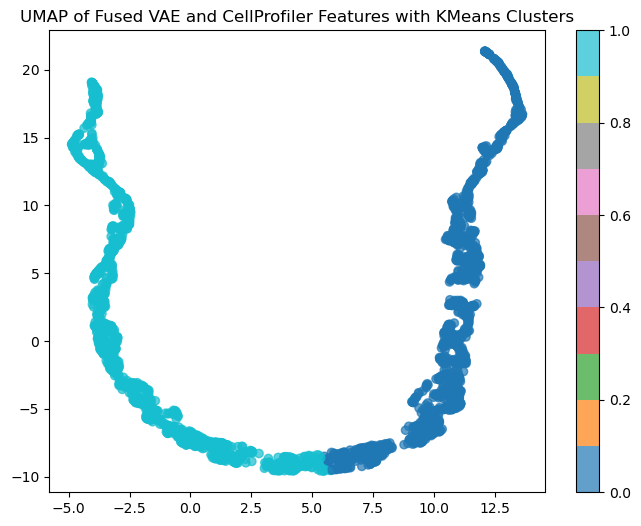

Mean Average Precision (mAP) using fused features: 0.0585


In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from PIL import Image
import numpy as np
import math
import matplotlib.pyplot as plt
import umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

# ------------------------------
# Define the VAE model
# ------------------------------
class VAE(nn.Module):
    def __init__(self, latent_dim=32):
        super(VAE, self).__init__()
        # Encoder: series of convolutional layers (input image assumed to be 224x224)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),  # (224 -> 112)
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # (112 -> 56)
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), # (56 -> 28)
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),# (28 -> 14)
            nn.ReLU(),
            nn.Conv2d(256, 512, 4, 2, 1),# (14 -> 7)
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(512*7*7, latent_dim)
        self.fc_logvar = nn.Linear(512*7*7, latent_dim)
        
        # Decoder: a fully-connected layer followed by transposed convolutions
        self.fc_decode = nn.Linear(latent_dim, 512*7*7)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1), # (7 -> 14)
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), # (14 -> 28)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # (28 -> 56)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),   # (56 -> 112)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),    # (112 -> 224)
            nn.Sigmoid()
        )
    
    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(-1, 512, 7, 7)
        return self.decoder(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

# ------------------------------
# Define a custom Dataset for VAE (using all_data)
# ------------------------------
class ImageDataset(Dataset):
    def __init__(self, data_list, transform=None):
        """
        Args:
            data_list: list of (filepath, compound_label_str)
            transform: torchvision transforms to apply to the image.
        """
        self.data_list = data_list
        self.transform = transform
        
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        fp, _ = self.data_list[idx]
        img = Image.open(fp).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

# ------------------------------
# Define data transformation: resize to 224x224 and convert to tensor.
# ------------------------------
transform_vae = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

# Create dataset using all_data (assumed to be defined previously)
vae_dataset = ImageDataset(all_data, transform=transform_vae)
vae_loader = DataLoader(vae_dataset, batch_size=16, shuffle=True)

# ------------------------------
# Instantiate and train VAE
# ------------------------------
latent_dim = 32
vae_model = VAE(latent_dim=latent_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae_model = vae_model.to(device)

optimizer = optim.Adam(vae_model.parameters(), lr=1e-4)

def vae_loss(recon_x, x, mu, logvar):
    """
    VAE loss: reconstruction loss (binary cross entropy) + KL divergence.
    """
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

num_epochs = 5
vae_model.train()
for epoch in range(num_epochs):
    train_loss = 0.0
    for images in vae_loader:
        images = images.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = vae_model(images)
        loss = vae_loss(recon, images, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_loss = train_loss / len(vae_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

# ------------------------------
# Extract VAE latent variables (mu) as embeddings.
# ------------------------------
vae_model.eval()
all_mu = []
with torch.no_grad():
    for images in vae_loader:
        images = images.to(device)
        _, mu, _ = vae_model(images)
        all_mu.append(mu.cpu().numpy())
vae_embeddings = np.concatenate(all_mu, axis=0)
print("VAE embeddings shape:", vae_embeddings.shape)  # Expected shape: (2867, 32)

# ------------------------------
# Integrate CellProfiler features.
# Assume df2 is read from "MyExpt_Image.csv" and cp_feat_dict is built.
# For example, cp_feat_dict: {prefix: numpy_array of selected CP features}
# Here we select three features: Count_IdentifyPrimaryObjects, Texture_Contrast_DNA_3_00_256, Texture_Entropy_DNA_3_00_256.
# ------------------------------
def get_prefix9(fname):
    """Extract the first 9 characters from the filename."""
    return fname[:9]

def get_cp_features(fp):
    """
    Given a file path, return the corresponding CellProfiler features from cp_feat_dict.
    If not found, return a zero vector of length 3.
    """
    prefix = get_prefix9(os.path.basename(fp))
    if prefix in cp_feat_dict:
        return cp_feat_dict[prefix]
    else:
        return np.zeros(3)

# Retrieve file paths for the VAE dataset (all_data)
# Since vae_dataset was built from all_data, we can extract filepaths directly.
all_filepaths = [fp for (fp, _) in all_data]

# Extract CellProfiler features for each sample
cp_features_list = []
for fp in all_filepaths:
    cp_feat = get_cp_features(fp)  # shape (3,)
    cp_features_list.append(cp_feat)
cp_features_array = np.stack(cp_features_list, axis=0)  # shape: [N, 3]
print("CellProfiler features shape:", cp_features_array.shape)

# ------------------------------
# Fuse VAE embeddings with CellProfiler features.
# VAE embeddings: [N, 32], CP features: [N, 3] -> fused features: [N, 35]
# ------------------------------
fused_features = np.concatenate([vae_embeddings, cp_features_array], axis=1)
print("Fused features shape:", fused_features.shape)

# ------------------------------
# Clustering and UMAP visualization on fused features.
# ------------------------------
k = 2  # Example: number of clusters
kmeans_fused = KMeans(n_clusters=k, random_state=42)
fused_cluster_labels = kmeans_fused.fit_predict(fused_features)

# Compute Silhouette Score for fused features
sil_score_fused = silhouette_score(fused_features, fused_cluster_labels)
print(f"Fused Features: Silhouette Score for k={k}: {sil_score_fused:.4f}")

# UMAP dimensionality reduction for visualization
umap_reducer_fused = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
umap_embeddings_fused = umap_reducer_fused.fit_transform(fused_features)

plt.figure(figsize=(8, 6))
plt.scatter(umap_embeddings_fused[:, 0], umap_embeddings_fused[:, 1], c=fused_cluster_labels, cmap='tab10', alpha=0.7)
plt.colorbar()
plt.title("UMAP of Fused VAE and CellProfiler Features with KMeans Clusters")
plt.show()

# ------------------------------
# mAP Analysis on fused features.
# ------------------------------
def compute_average_precision(similarity_matrix, true_labels, sample_idx):
    """
    Compute average precision for one sample based on similarity ranking.
    
    Args:
        similarity_matrix: [N, N] array of cosine similarities.
        true_labels: [N] array of ground truth labels.
        sample_idx: index of the sample to compute AP.
    
    Returns:
        average_precision: average precision for that sample.
    """
    sim = similarity_matrix[sample_idx].copy()
    sim[sample_idx] = -1e9  # Exclude self-similarity
    ranking = np.argsort(-sim)
    true_positive = (true_labels[ranking] == true_labels[sample_idx]).astype(np.int32)
    cumulative_true = np.cumsum(true_positive)
    precision_at_k = cumulative_true / (np.arange(1, len(true_positive)+1))
    if cumulative_true[-1] == 0:
        return 0.0
    average_precision = np.sum(precision_at_k * true_positive) / cumulative_true[-1]
    return average_precision

def compute_mAP(embeddings, true_labels):
    """
    Compute mean Average Precision (mAP) for the dataset based on cosine similarity.
    """
    sim_matrix = cosine_similarity(embeddings)
    APs = []
    for i in range(len(true_labels)):
        AP = compute_average_precision(sim_matrix, true_labels, i)
        APs.append(AP)
    mAP = np.mean(APs)
    return mAP

# Assume that the true labels (compound labels) are available from all_data.
# Build true labels array from all_data using label_to_idx.
all_labels = []
for _, lab_str in all_data:
    all_labels.append(label_to_idx[lab_str])
all_labels = np.array(all_labels)

map_score_fused = compute_mAP(fused_features, all_labels)
print(f"Mean Average Precision (mAP) using fused features: {map_score_fused:.4f}")
